In [7]:
from mundilib import MundiCatalogue
from utils import height2width
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Init wms
c = MundiCatalogue()

wms1 = c.get_collection("Sentinel1").mundi_wms('GRD')
wms2 = c.get_collection("Sentinel2").mundi_wms('L2A')

In [8]:
_projection_ = 'EPSG:4326'
_bbox_       = (15.68727199494822, 44.6026039846487, 16.10475246369822, 44.8003578908987)
_time_       = '2022-05-06/2023-05-10'
_height_     = 512
_width_      = height2width(_bbox_, _height_)

In [9]:
layers1 = list(wms1.contents)
layers2 = list(wms2.contents)

In [10]:
img1 = wms1.getmap(layers=[layers1[1]],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)


img2 = wms2.getmap(layers=['SCL_GRAYSCALE'],
                     srs=_projection_,
                     bbox=_bbox_,
                     size=(_width_, _height_),
                     format='image/tiff',
                     time=_time_,
                     showlogo=False,
                     transparent=False)
img2_arr = np.asarray(Image.open(img2))
img2_arr = img2_arr // 23 

In [11]:
grid1 = np.asarray(Image.open(img1))
grid1 = grid1[:,:,0] / grid1[:,:,1]

grid2 = np.zeros(img2_arr.shape)

for i in range(grid2.shape[0]):
    for j in range(grid2.shape[1]):
        if img2_arr[i][j] == 6:
            grid2[i][j] = 0.95
        elif img2_arr[i][j] == 11:
            grid2[i][j] = 0.75
        elif img2_arr[i][j] == 4:
            grid2[i][j] = 0.25
        else:
            grid2[i][j] = 0.0

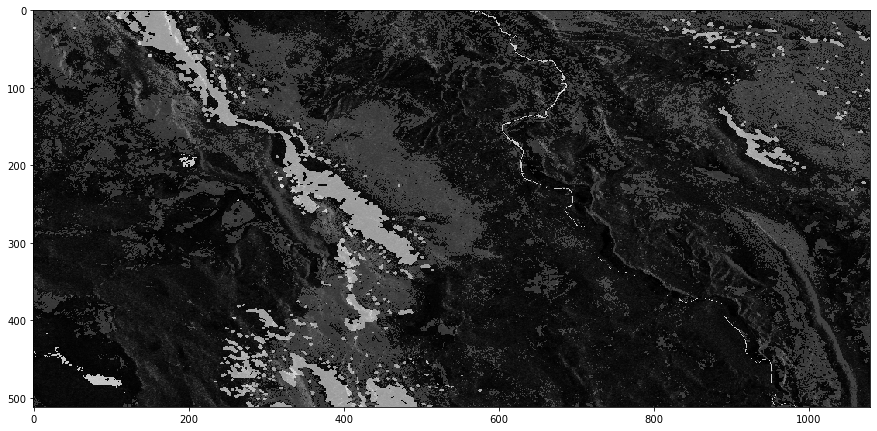

In [17]:
grid = 0.25 * grid1 + 0.75 * grid2
npmin = np.min(grid)
grid = grid - npmin
npmax = np.max(grid)
grid = grid / npmax

plt.figure(figsize=(15, 15))
plt.imshow(grid, cmap='gray')
plt.show()

In [107]:
def bfs(grid, x1, y1, x2, y2):
    # Define possible movements
    movements = [(1, 0), (1, 1), (-1, 1), (-1, 0), (0, 1), (0, -1), (-1, -1), (1, -1)]
    
    # Initialize visited, queue, and distance dictionaries
    visited = {(x1, y1): None}
    queue = [(x1, y1)]
    distance = {(x1, y1): grid[x1][y1]}
    
    while queue:
        # Get the next vertex to explore from the queue
        curr_x, curr_y = queue.pop(0)
        
        # Check if we've reached the destination
        if curr_x == x2 and curr_y == y2:
            # Build the path by backtracking from the destination to the start
            path = [(x2, y2)]
            while path[-1] != (x1, y1):
                path.append(visited[path[-1]])
            path.reverse()
            print("done!")
            return path, distance[(x2, y2)]
        
        # Explore neighbors
        for dx, dy in movements:
            neighbor_x, neighbor_y = curr_x + dx, curr_y + dy
            # Check if neighbor is inside the grid
            if neighbor_x >= 0 and neighbor_x < len(grid) and neighbor_y >= 0 and neighbor_y < len(grid[0]):
                # Calculate the distance to the neighbor and add it to the total distance
                neighbor_distance = max(distance[(curr_x, curr_y)], grid[neighbor_x][neighbor_y])
                # Check if the neighbor has not been visited or if this is a shorter path to the neighbor
                if (neighbor_x, neighbor_y) not in visited or neighbor_distance < distance[(neighbor_x, neighbor_y)]:
                    visited[(neighbor_x, neighbor_y)] = (curr_x, curr_y)
                    distance[(neighbor_x, neighbor_y)] = neighbor_distance
                    queue.append((neighbor_x, neighbor_y))
                    
    # If we get here, it means there's no path from (x1, y1) to (x2, y2)
    return None, None

In [122]:
a = (350, 180)
b1 = (350, 500)
b2 = (450, 500)
b3 = (100, 300)

res1 = bfs(grid, a[0], a[1], b1[0], b1[1])
res2 = bfs(grid, a[0], a[1], b2[0], b2[1])
res3 = bfs(grid, a[0], a[1], b3[0], b3[1])

done!
done!
done!


In [123]:
color_grid = np.zeros((grid.shape[0], grid.shape[1], 3))
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        color_grid[i][j][0] = grid[i][j]
        color_grid[i][j][1] = grid[i][j]
        color_grid[i][j][2] = grid[i][j]
for r in res1[0]:
    movements = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    for dx, dy in movements:
        color_grid[r[0] + dx][r[1] + dy] = [255, 0, 0]
            
for r in res2[0]:
    movements = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    for dx, dy in movements:
        color_grid[r[0] + dx][r[1] + dy] = [255, 0, 0]
            
for r in res3[0]:
    movements = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    for dx, dy in movements:
        color_grid[r[0] + dx][r[1] + dy] = [255, 0, 0]
        
movements = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
for dx, dy in movements:
    color_grid[a[0] + dx][a[1] + dy] = [0, 255, 255]
    color_grid[a[0] + 2 * dx][a[1] + 2 * dy] = [0, 255, 255]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


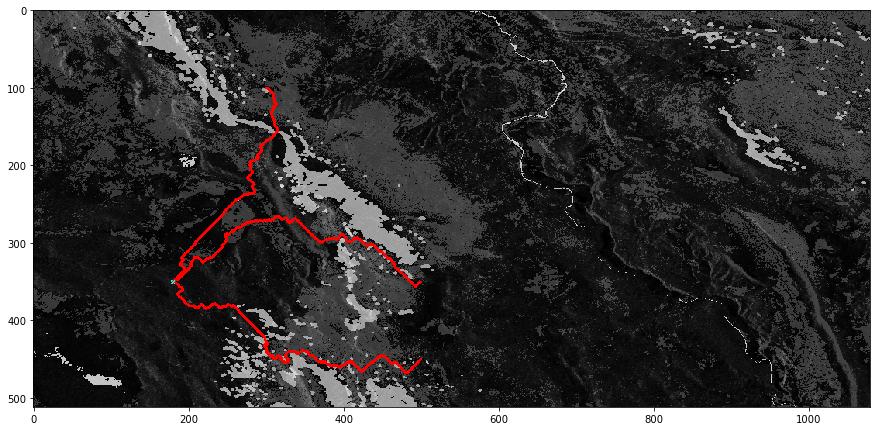

In [126]:
plt.figure(figsize=(15, 15))
plt.imshow(color_grid, cmap='gray')
plt.savefig('color_grid.png')
plt.show()